In [26]:
# %matplotlib widget

In [27]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import itertools

In [28]:
leagueid = 299
df = pd.read_pickle(f'pickles/299-roles.pkl')

[None, None]

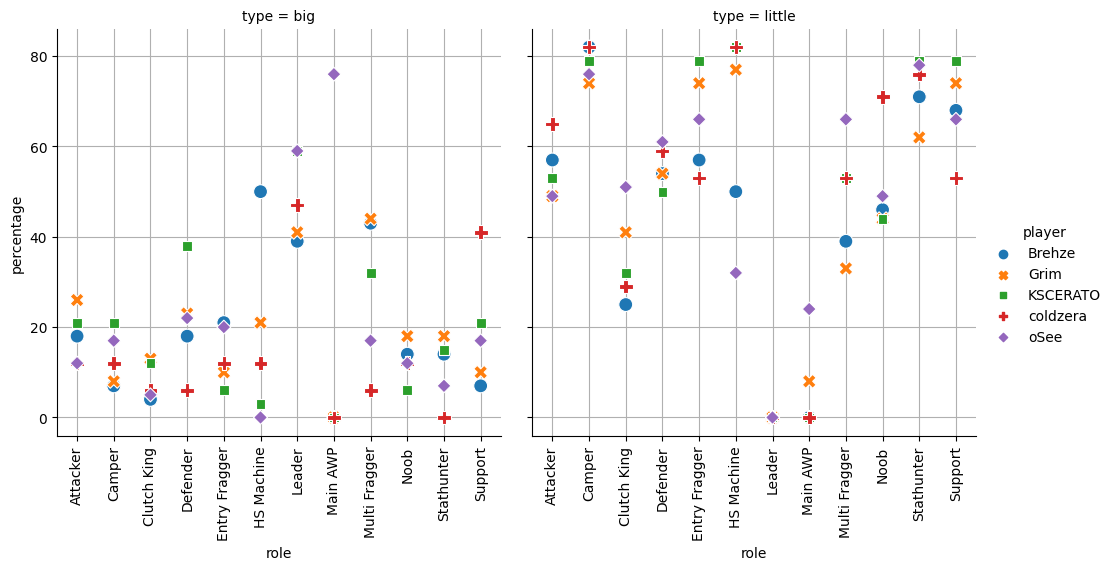

In [29]:
# scatter

# need to melt big and little for sns relplot
dfm = df.melt(id_vars=['role', 'player'], value_vars=['big', 'little'], var_name='type', value_name='percentage')

axgrid = sns.relplot(
    data=dfm, x='role', y='percentage',
    col='type',
    hue="player", style="player",
    kind="scatter",
    s=100,
    zorder=5
)

[ax.tick_params(axis='x', rotation=90) for ax in axgrid.axes.ravel()]
[ax.grid(zorder=1, which='major') for ax in axgrid.axes.ravel()]

<AxesSubplot:xlabel='None-player', ylabel='role'>

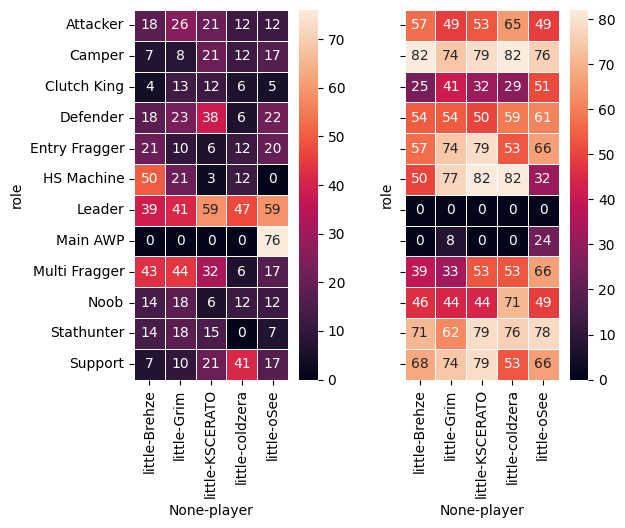

In [30]:
# heatmap

fig, axs = plt.subplots(1,2, sharex=True, sharey=True)

sns.heatmap(
    data=df.pivot(index=['role'], columns=['player'], values=['big']),
    linewidths=.5,
    annot=True, square=True,
    # cbar=False,
    # vmin=0, vmax=50,
    ax=axs[0]
)

sns.heatmap(
    data=df.pivot(index=['role'], columns=['player'], values=['little']),
    linewidths=.5,
    annot=True, square=True,
    # cbar=False,
    # vmin=0, vmax=50,
    ax=axs[1]
)

In [31]:
def lazy_top5(df, by):
    picks = pd.DataFrame(columns=df.columns)

    for _ in range(5):
        tmp = df[df.apply(lambda x: x['player'] not in list(picks['player']) and x['role'] not in list(picks['role']), axis=1)].sort_values(by=by, ascending=False).iloc[0]
        picks = pd.concat([picks, tmp.to_frame().T])
    
    return picks


picks = lazy_top5(df, 'big')
display(picks)
print(f"{picks['big'].sum()=}, {picks['little'].sum()=}")

picks = lazy_top5(df, 'little')
display(picks)
print(f"{picks['big'].sum()=}, {picks['little'].sum()=}")


,role,player,big,little
55,Main AWP,oSee,76,24
30,Leader,KSCERATO,59,0
5,HS Machine,Brehze,50,50
20,Multi Fragger,Grim,44,33
47,Support,coldzera,41,53


picks['big'].sum()=270, picks['little'].sum()=160


,role,player,big,little
41,HS Machine,coldzera,12,82
1,Camper,Brehze,7,82
35,Support,KSCERATO,21,79
58,Stathunter,oSee,7,78
16,Entry Fragger,Grim,10,74


picks['big'].sum()=57, picks['little'].sum()=395


In [32]:
def maybe_smarter_top5(df, by):
    # First collect all name / role combinations that can make sense.
    # Keep looking for another role for a player, if at least one more 
    # player has that role as maximum role also.

    df_role_per_name = df.groupby('player', group_keys=True).apply(lambda x: x[['role', 'big', 'little']].sort_values(by=by, ascending=False))

    names = df['player'].unique()
    spots = len(names)
    roles = df['role'].unique()

    options_dict = {}
    roleidx = 0
    for roleidx in range(len(roles)):
        for name in names:
            # x = df_role_per_name.loc[name].iloc[roleidx]
            index_in_df = df_role_per_name.loc[name].index[roleidx]
            role = df.iloc[index_in_df]['role']
            # raise SystemExit((f'{role.iloc[0]=}'))
            # raise SystemExit(f'{df.iloc[index_in_df]=}')
            # role = x['role']
            # percentage = x[by]
            try:
                options_dict[role]['indices'].append(index_in_df)
                options_dict[role]['role_needs_another_pass'] = True
            except KeyError:
                options_dict[role] = {'indices': [index_in_df], 'role_needs_another_pass': False}

        names = []

        for role, roledata in options_dict.items():
            if roledata['role_needs_another_pass']:# and len(options_dict[role]['names']) > 1:
                # print(f'{role=} needs another pass')
                # raise SystemExit(f'{[x for x in df["player"].iloc[roledata["indices"]]]}')
                names = df["player"].iloc[roledata["indices"]]
            options_dict[role]['role_needs_another_pass'] = False

        if len(names) == 0:
            break

    flatten_indices = [index for x in options_dict.values() for index in x['indices']]

    # Generate all 5 pick options, then filter out proper ones.
    comps = itertools.combinations(flatten_indices, r=5)
    def filter_comps(comps):
        for comp in comps:
            if len(df.iloc[list(comp)]['player'].unique()) == spots and len(df.iloc[list(comp)]['role'].unique()) == spots:
                yield comp
    filtered_comps = filter_comps(comps)

    # Find maximum sum.
    def sum_comp(comp):
        return df.iloc[list(comp)][by].sum()
    picked_comp = max(filtered_comps, key=lambda x: sum_comp(x))
    
    return picked_comp

picked_comp = maybe_smarter_top5(df, 'big')
display(df.iloc[list(picked_comp)])
print(f'{df.iloc[list(picked_comp)]["big"].sum()=} {df.iloc[list(picked_comp)]["little"].sum()=}')

picked_comp = maybe_smarter_top5(df, 'little')
display(df.iloc[list(picked_comp)])
print(f'{df.iloc[list(picked_comp)]["big"].sum()=} {df.iloc[list(picked_comp)]["little"].sum()=}')


,role,player,big,little
5,HS Machine,Brehze,50,50
20,Multi Fragger,Grim,44,33
30,Leader,KSCERATO,59,0
55,Main AWP,oSee,76,24
47,Support,coldzera,41,53


df.iloc[list(picked_comp)]["big"].sum()=270 df.iloc[list(picked_comp)]["little"].sum()=160


,role,player,big,little
37,Camper,coldzera,12,82
17,HS Machine,Grim,21,77
58,Stathunter,oSee,7,78
11,Support,Brehze,7,68
28,Entry Fragger,KSCERATO,6,79


df.iloc[list(picked_comp)]["big"].sum()=53 df.iloc[list(picked_comp)]["little"].sum()=384


In [33]:
df

,role,player,big,little
0,Attacker,Brehze,18,57
1,Camper,Brehze,7,82
2,Clutch King,Brehze,4,25
3,Defender,Brehze,18,54
4,Entry Fragger,Brehze,21,57
5,HS Machine,Brehze,50,50
6,Leader,Brehze,39,0
7,Main AWP,Brehze,0,0
8,Multi Fragger,Brehze,43,39
9,Noob,Brehze,14,46


In [34]:
df.groupby('player', group_keys=True).apply(lambda x: x[['role', 'big', 'little']].sort_values(by='big', ascending=False))

role  big  little
player                                 
Brehze   5      HS Machine   50      50
         8   Multi Fragger   43      39
         6          Leader   39       0
         4   Entry Fragger   21      57
         0        Attacker   18      57
         3        Defender   18      54
         9            Noob   14      46
         10     Stathunter   14      71
         1          Camper    7      82
         11        Support    7      68
         2     Clutch King    4      25
         7        Main AWP    0       0
Grim     20  Multi Fragger   44      33
         18         Leader   41       0
         12       Attacker   26      49
         15       Defender   23      54
         17     HS Machine   21      77
         21           Noob   18      44
         22     Stathunter   18      62
         14    Clutch King   13      41
         16  Entry Fragger   10      74
         23        Support   10      74
         13         Camper    8      74
         19       Main AWP    0       8
KSCERATO 30         Leader   59       0
         27       Defender   38      50
         32  Multi Fragger   32      53
         24       Attacker   21      53
         25         Camper   21      79
         35        Support   21      79
         34     Stathunter   15      79
         26    Clutch King   12      32
         28  Entry Fragger    6      79
         33           Noob    6      44
         29     HS Machine    3      82
         31       Main AWP    0       0
coldzera 42         Leader   47       0
         47        Support   41      53
         36       Attacker   12      65
         37         Camper   12      82
         40  Entry Fragger   12      53
         41     HS Machine   12      82
         45           Noob   12      71
         38    Clutch King    6      29
         39       Defender    6      59
         44  Multi Fragger    6      53
         43       Main AWP    0       0
         46     Stathunter    0      76
oSee     55       Main AWP   76      24
         54         Leader   59       0
         51       Defender   22      61
         52  Entry Fragger   20      66
         49         Camper   17      76
         56  Multi Fragger   17      66
         59        Support   17      66
         48       Attacker   12      49
         57           Noob   12      49
         58     Stathunter    7      78
         50    Clutch King    5      51
         53     HS Machine    0      32

In [35]:
df.sort_values(by='big', ascending=False)

,role,player,big,little
55,Main AWP,oSee,76,24
30,Leader,KSCERATO,59,0
54,Leader,oSee,59,0
5,HS Machine,Brehze,50,50
42,Leader,coldzera,47,0
20,Multi Fragger,Grim,44,33
8,Multi Fragger,Brehze,43,39
18,Leader,Grim,41,0
47,Support,coldzera,41,53
6,Leader,Brehze,39,0


In [36]:
df.groupby('role', group_keys=True).apply(lambda x: x[['player', 'big', 'little']].sort_values(by='big', ascending=False, ignore_index=True))

player  big  little
role                                  
Attacker      0      Grim   26      49
              1  KSCERATO   21      53
              2    Brehze   18      57
              3  coldzera   12      65
              4      oSee   12      49
Camper        0  KSCERATO   21      79
              1      oSee   17      76
              2  coldzera   12      82
              3      Grim    8      74
              4    Brehze    7      82
Clutch King   0      Grim   13      41
              1  KSCERATO   12      32
              2  coldzera    6      29
              3      oSee    5      51
              4    Brehze    4      25
Defender      0  KSCERATO   38      50
              1      Grim   23      54
              2      oSee   22      61
              3    Brehze   18      54
              4  coldzera    6      59
Entry Fragger 0    Brehze   21      57
              1      oSee   20      66
              2  coldzera   12      53
              3      Grim   10      74
              4  KSCERATO    6      79
HS Machine    0    Brehze   50      50
              1      Grim   21      77
              2  coldzera   12      82
              3  KSCERATO    3      82
              4      oSee    0      32
Leader        0  KSCERATO   59       0
              1      oSee   59       0
              2  coldzera   47       0
              3      Grim   41       0
              4    Brehze   39       0
Main AWP      0      oSee   76      24
              1    Brehze    0       0
              2      Grim    0       8
              3  KSCERATO    0       0
              4  coldzera    0       0
Multi Fragger 0      Grim   44      33
              1    Brehze   43      39
              2  KSCERATO   32      53
              3      oSee   17      66
              4  coldzera    6      53
Noob          0      Grim   18      44
              1    Brehze   14      46
              2  coldzera   12      71
              3      oSee   12      49
              4  KSCERATO    6      44
Stathunter    0      Grim   18      62
              1  KSCERATO   15      79
              2    Brehze   14      71
              3      oSee    7      78
              4  coldzera    0      76
Support       0  coldzera   41      53
              1  KSCERATO   21      79
              2      oSee   17      66
              3      Grim   10      74
              4    Brehze    7      68